# Preparing corpus

## Load data

In [1]:
%%bash
pip install -U 'scikit-learn<0.24'
pip install python_crfsuite sklearn_crfsuite

In [2]:
import os
import sys
import torch
import pandas as pd
import torch.nn.functional as F
from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import numpy as np
import sklearn.metrics as mt
import matplotlib.pyplot as plt
from sklearn_crfsuite import CRF
from typing import Tuple

drive_path = 'drive/MyDrive/Colab Notebooks/NLU Final Project/'
sys.path.insert(0, os.path.abspath(drive_path))

import conll

train_set = [sent for sent in conll.read_corpus_conll(drive_path + 'data/conll/train.txt') if '-DOCSTART-' not in sent[0][0]]
test_set = [sent for sent in conll.read_corpus_conll(drive_path + 'data/conll/test.txt') if '-DOCSTART-' not in sent[0][0]]
val_set = [sent for sent in conll.read_corpus_conll(drive_path + 'data/conll/dev.txt') if '-DOCSTART-' not in sent[0][0]]

# reshape dataset
train_set = [[(token[0].split()[0], token[0].split()[-1]) for token in sent] for sent in train_set]
test_set = [[(token[0].split()[0], token[0].split()[-1]) for token in sent] for sent in test_set]
val_set = [[(token[0].split()[0], token[0].split()[-1]) for token in sent] for sent in val_set]

print(train_set[0][:4])
print(test_set[0][:4])
print(val_set[0][:4])

# link for comparisons
# https://spacy.io/usage/facts-figures

[('EU', 'B-ORG'), ('rejects', 'O'), ('German', 'B-MISC'), ('call', 'O')]
[('SOCCER', 'O'), ('-', 'O'), ('JAPAN', 'B-LOC'), ('GET', 'O')]
[('CRICKET', 'O'), ('-', 'O'), ('LEICESTERSHIRE', 'B-ORG'), ('TAKE', 'O')]


## Preparing data

### Define function to get vocabulary of words and tags (labels)

In [3]:
# idx specifies the index of the colunm to get (0: words, -1: tags)
def get_vocabulary(data, idx=0):
    vocab = set()
    for sent in data:
        for token in sent:
            vocab.add(token[idx])
    return sorted(list(vocab))

### Create numerical mappings for words and tags

In [4]:
def create_mapping(vocabulary, initial=None):
    idx = {} if initial is None else initial

    idx.update(
        {w: i + len(idx) for i, w in enumerate(vocabulary)}
        )
    return idx

In [5]:
# get vocab
words = get_vocabulary(train_set)
labels = get_vocabulary(train_set, -1)

# word mappings

# word to index
# word index
word2idx = create_mapping(words, initial={"<PAD>":0, "<UNK>":1})

# index to word, the inverse of the previous map
# allowed since indexes are unique
idx2word = {v: k for k, v in word2idx.items()}

# labels mappings

# label to index
label2idx = create_mapping(labels)

# index to label, the inverse of the previous map
# allowed since indexes are unique
idx2label = {v: k for k, v in label2idx.items()}

### Pad and truncate

In [6]:
def pad_and_truncate(sequences, max_len, value):

  for i, seq in enumerate(sequences):
    l = len(seq)
    if l > max_len:
      # truncate
      sequences[i] = seq[:max_len]
    else:
      # pad
      delta = max_len - l
      pad = [value for i in range(delta)]
      seq.extend(pad)
      sequences[i] = seq
  
  return sequences

Prepare in advance a function to unpad e change the format for CoNLL evaluation

In [7]:
def unpad(preds, test_set):
  refs = deepcopy(test_set)
  if len(preds) != len(refs):
    raise ValueError

  hyps = []
  
  for i, sent in enumerate(refs):
    if len(sent) < len(preds[i]):
      # sentence has been padded
      hyps.append(preds[i][:len(sent)])
    
    elif len(sent) > len(preds[i]):
      # sentence has been truncated
      # in this case its necessary to truncate
      # also the ground truth so that they can be
      # compared
      refs[i] = refs[i][:len(preds[i])]
      hyps.append(preds[i])
    
    elif len(sent) == len(preds[i]):
      hyps.append(preds[i])

  return hyps, refs

In [8]:
def format_predictions_for_conll(preds, idx2label):
  return [[('_', idx2label.get(i)) for i in s] for s in preds]

In [9]:
def unpad_accuracy(preds: torch.Tensor, test_set: list, y_flat: np.ndarray = None) -> Tuple[np.float64, list, list]:
  preds = preds.cpu().numpy()
  preds, truths = unpad(preds, test_set)

  flat_preds = np.array([])
  flat_truths = np.array([])

  for np_arr in preds:
    flat_preds = np.append(flat_preds, np_arr)

  if y_flat is None:
    for sent in truths:
      for tuple_ in sent:
        flat_truths = np.append(flat_truths, label2idx[tuple_[1]])
  else:
    flat_truths = y_flat

  if len(flat_truths) != len(flat_preds):
    raise ValueError

  return mt.accuracy_score(flat_truths, flat_preds), preds, truths

## Define functions to prepare the dataset and the train step for later

### Train set

In [10]:
def prepare_train(train_set, labels, word2idx, label2idx, max_len=None):
  # vectorize data
  x_train_int = [[word2idx[w] for w, t in s] for s in train_set]

  # print("Train textual: {}".format(list(map(lambda x: x[0], train_set[0]))))
  # print("Train encoded: {}".format(x_train_int[0]))

  # padding and truncating

  # get max length
  if max_len is None:
    max_len = max(map(len, x_train_int))

  x_len = [min(len(sent), max_len) for sent in train_set]
  x_len = torch.tensor(x_len)

  # pad the sentences to max length
  x_train_pad = pad_and_truncate(x_train_int, max_len, word2idx['<PAD>'])

  # vectorize labels
  y_train_int = [[label2idx[t] for w, t in s] for s in train_set]
  y_train_pad = pad_and_truncate(deepcopy(y_train_int), max_len, label2idx['O'])

  x_train_pad = torch.tensor(x_train_pad)
  y_train_pad = torch.tensor(y_train_pad)

  # 8 is the id of 'O'
  # print("Textual: {}".format(list(map(lambda x: x[1], train_set[0]))))
  # print("Encoded & Padded: {}".format(y_train_pad[0]))

  # one-hot encoding for labels
  y_train_ohv = F.one_hot(y_train_pad, num_classes=len(labels))

  # flatten for later
  y_train_flat = np.array([])

  for elem in y_train_int:
    y_train_flat = np.append(y_train_flat, elem[:max_len])

  return x_train_pad, y_train_ohv.float(), y_train_flat, max_len, x_len

### Test Set

In [11]:
def prepare_test(test_set, labels, word2idx, label2idx, max_len):
  # replace words not in training with <UNK>
  # insert in X_test_int the index of the word if it is in the vocabulary
  # otherwise inserts the index for <UNK>
  x_test_int = [[word2idx.get(w, word2idx.get('<UNK>')) for w, t in s] for s in test_set]

  x_len = [min(len(sent), max_len) for sent in test_set]
  x_len = torch.tensor(x_len)

  x_test_pad = pad_and_truncate(x_test_int, max_len, word2idx['<PAD>'])

  # replace tags not in training with 'O'
  # same way as before
  y_test_int = [[label2idx.get(t, label2idx.get('O')) for w, t in s] for s in test_set]
  y_test_pad = pad_and_truncate(deepcopy(y_test_int), max_len, label2idx['O'])

  x_test_pad = torch.tensor(x_test_pad)
  y_test_pad = torch.tensor(y_test_pad)

  # to one-hot encoding
  y_test_ohv = F.one_hot(y_test_pad, num_classes=len(labels))

  # flatten for later
  y_test_flat = np.array([])

  for elem in y_test_int:
    y_test_flat = np.append(y_test_flat, elem[:max_len])

  return x_test_pad, y_test_ohv.float(), y_test_flat, x_len

## Putting all in a Dataset object

In [12]:
# mean_len = int(sum(map(len, train_set))/len(train_set))
# print(mean_len)

X_train, Y_train, y_train_flat, max_len, x_train_len = prepare_train(train_set, labels, word2idx, label2idx)
X_test, Y_test, y_test_flat, x_test_len = prepare_test(test_set, labels, word2idx, label2idx, max_len)
X_val, Y_val, y_val_flat, x_val_len = prepare_test(val_set, labels, word2idx, label2idx, max_len)

train_dataset = TensorDataset(X_train, Y_train, x_train_len)

# Define train step

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
def train_step(X, Y, x_len, model, loss_f, optimizer):
  model.zero_grad()

  # Get model predictions
  pred = model(X, x_len)

  # Computes loss
  loss = loss_f(pred, Y)

  # Computes gradients
  loss.backward()

  # Updates parameters and zeroes gradients
  optimizer.step()

  # Returns the loss
  return loss.item()

# Create and train a BiLSTM

## Define the model

In [15]:
class BiLSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pad_value, max_len):
    super(BiLSTM, self).__init__()

    self.pad_value = pad_value
    self.max_len = max_len

    self.hidden_dim = hidden_dim

    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_value)

    self.dropout = nn.Dropout(0.5)

    # The LSTM takes word embeddings as inputs, and outputs hidden states
    # with dimensionality hidden_dim.
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)

    # The linear layer that maps from hidden state space to tag space
    self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    self.softmax = nn.Softmax(dim=2)

  def forward(self, sentences, x_len):
    # INPUT: batch size (= number of sentences) x len (= number of tokens)

    # EMBEDS: # batch size x len x embedding_dim
    # B sentences composed of L tokens, one embedding for token
    embeds = self.word_embeddings(sentences)
    embeds = self.dropout(embeds)

    # sort sentences and lengths by length, then pack sequences
    # _, sort_idx = torch.sort(embeds, descending=True)
    # _, unsort_idx = torch.sort(sort_idx)

    # pack sequences
    embeds = nn.utils.rnn.pack_padded_sequence(embeds, x_len, batch_first=True, enforce_sorted=False)

    # LSTM_OUT: batch x len x hidden_dim * 2 (because it is bidirectional)
    lstm_out, _ = self.lstm(embeds)

    # unpack
    lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True, padding_value=self.pad_value, total_length=self.max_len)

    # TAG_SPACE: batch x len x tagset_size
    # for each token in each sentence Linear gives a vector of scores, one for each class/label
    tag_space = self.hidden2tag(lstm_out)

    # convert to probabilities
    tag_scores = self.softmax(tag_space)
    
    return tag_scores

In [16]:
model = BiLSTM(
    embedding_dim=64, # embedding output
    hidden_dim=64, # lstm output
    vocab_size=len(words)+2,
    tagset_size=len(labels),
    pad_value=word2idx['<PAD>'],
    max_len = max_len
).to(device)

model_saved = False

if os.path.isfile(drive_path + "models/bilstm"):
  model.load_state_dict(torch.load(drive_path + "models/bilstm", map_location=torch.device(device)))
  model_saved = True
  print("Model loaded")

# model_saved = False

model

BiLSTM(
  (word_embeddings): Embedding(23625, 64, padding_idx=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=9, bias=True)
  (softmax): Softmax(dim=2)
)

## Training the model

In [17]:
def train_model(model, train_dataset, X_train, X_val, train_set, val_set, y_train_flat, y_val_flat, x_train_len, x_val_len, bs, epochs, print_every, device):
  train_dataloader = DataLoader(
    train_dataset,
    batch_size=bs,
    shuffle=True
    )
  
  loss_f = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  loss = 0
  losses = []
  train_accs = []
  val_accs = []

  tot_batches = len(train_dataloader)
  
 
  for e in range(epochs):
    processed = 0

    for X_batch, Y_batch, x_batch_len in train_dataloader:
      model.train()

      loss = train_step(X_batch.to(device), Y_batch.to(device), x_batch_len, model, loss_f, optimizer)
      losses.append(loss)

      processed += 1


      if processed % print_every == 0:
        # validation
        v_acc, _, _ = evaluate_model(model, X_val, val_set, y_val_flat, x_val_len, device)
        t_acc, _, _ = evaluate_model(model, X_train, train_set, y_train_flat, x_train_len, device)

        train_accs.append(t_acc)
        val_accs.append(v_acc)

        print(f"\rEpoch:{e+1}/{epochs}, Batches: {processed}/{tot_batches}, Loss: {loss}, Train acc: {t_acc} Val acc: {v_acc}")
  
  return losses, train_accs, val_accs

In [18]:
def evaluate_model(model, X, test_set, y_flat, x_len, device):
  model.eval()

  predictions = None

  with torch.no_grad():

    # recover labels from probabilities
    preds = model(X.to(device), x_len)
    preds = preds.argmax(dim=2)

    return unpad_accuracy(preds, test_set, y_flat)

Epoch:1/10, Batches: 100/235, Loss: 0.14615298807621002, Train acc: 0.8624994475029589 Val acc: 0.8604026322962501
Epoch:1/10, Batches: 200/235, Loss: 0.05429716035723686, Train acc: 0.914296658989004 Val acc: 0.9022234336669133
Epoch:2/10, Batches: 100/235, Loss: 0.02649277076125145, Train acc: 0.9461843326572407 Val acc: 0.9315252521319263
Epoch:2/10, Batches: 200/235, Loss: 0.0175880566239357, Train acc: 0.958128090914002 Val acc: 0.938320158872318
Epoch:3/10, Batches: 100/235, Loss: 0.010677400045096874, Train acc: 0.9683087697241444 Val acc: 0.9480939215762626
Epoch:3/10, Batches: 200/235, Loss: 0.009349801577627659, Train acc: 0.9741676939019059 Val acc: 0.9536622405669561
Epoch:4/10, Batches: 100/235, Loss: 0.008551817387342453, Train acc: 0.9779590513748582 Val acc: 0.9560570071258907
Epoch:4/10, Batches: 200/235, Loss: 0.0073858704417943954, Train acc: 0.9824821604844294 Val acc: 0.9587243487403139
Epoch:5/10, Batches: 100/235, Loss: 0.004525650758296251, Train acc: 0.98545827

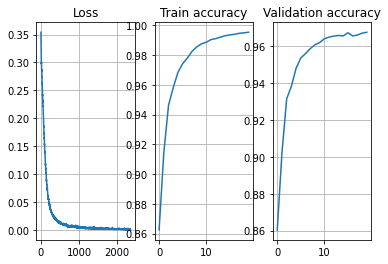

In [19]:
if not model_saved:
  losses, train_accs, val_accs = train_model(model=model,
                       train_dataset=train_dataset,
                       X_train=X_train,
                       X_val=X_val,
                       train_set=train_set,
                       val_set=val_set,
                       y_train_flat=y_train_flat,
                       y_val_flat=y_val_flat,
                       x_train_len=x_train_len,
                       x_val_len=x_val_len,
                       bs=60,
                       epochs=10,
                       print_every=100, 
                       device=device)
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

  ax1.plot(range(len(losses)), losses)
  ax1.set_title("Loss")
  ax1.grid()

  ax2.plot(range(len(train_accs)), train_accs)
  ax2.set_title("Train accuracy")
  ax2.grid()

  ax3.plot(range(len(val_accs)), val_accs)
  ax3.set_title("Validation accuracy")
  ax3.grid()

In [20]:
# saving the model
if not model_saved:
  print("Saving the model for later use")
  torch.save(model.state_dict(), drive_path + "models/bilstm")

Saving the model for later use


## Evaluating the model

In [21]:
acc, preds_unpadded, truncated_truths = evaluate_model(model, X_test, test_set, y_test_flat, x_test_len, device)
print(f'Test accuracy: {acc*100}')

Test accuracy: 95.09090125797002


## CoNLL evaluation

In [22]:
results = conll.evaluate(truncated_truths, format_predictions_for_conll(preds_unpadded, idx2label))
pd_tbl = pd.DataFrame().from_dict(results, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
ORG,0.781,0.639,0.703,1661
MISC,0.733,0.687,0.709,702
PER,0.744,0.752,0.748,1616
LOC,0.841,0.829,0.835,1667
total,0.782,0.733,0.757,5646


# CRF

## Features

In [23]:
def word2features(sent, i):
    word = sent[i][0]
    return {'bias': 1.0, 'word.lower()': word.lower()}

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [24]:
train_crf_feats = [sent2features(s) for s in train_set]
train_crf_labels = [sent2labels(s) for s in train_set]

In [25]:
train_crf_feats[0][0]

{'bias': 1.0, 'word.lower()': 'eu'}

## Training

In [26]:
crf = CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)

repr(crf)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


"CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,\n    keep_tempfiles=None, max_iterations=100)"

In [27]:
%%time
crf.fit(train_crf_feats, train_crf_labels)

CPU times: user 11.7 s, sys: 40.3 ms, total: 11.7 s
Wall time: 11.7 s


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

## Evaluation

In [28]:
test_feats = [sent2features(s) for s in test_set]
pred_crf = crf.predict(test_feats)

# convert to tuples for conll evaluation
pred_crf = [[(test_feats[i][j], t) for j, t in enumerate(tokens)] for i, tokens in enumerate(pred_crf)]

pred_crf[0]

[({'bias': 1.0, 'word.lower()': 'soccer'}, 'O'),
 ({'bias': 1.0, 'word.lower()': '-'}, 'O'),
 ({'bias': 1.0, 'word.lower()': 'japan'}, 'B-LOC'),
 ({'bias': 1.0, 'word.lower()': 'get'}, 'O'),
 ({'bias': 1.0, 'word.lower()': 'lucky'}, 'O'),
 ({'bias': 1.0, 'word.lower()': 'win'}, 'O'),
 ({'bias': 1.0, 'word.lower()': ','}, 'O'),
 ({'bias': 1.0, 'word.lower()': 'china'}, 'B-LOC'),
 ({'bias': 1.0, 'word.lower()': 'in'}, 'O'),
 ({'bias': 1.0, 'word.lower()': 'surprise'}, 'O'),
 ({'bias': 1.0, 'word.lower()': 'defeat'}, 'O'),
 ({'bias': 1.0, 'word.lower()': '.'}, 'O')]

In [29]:
results = conll.evaluate(test_set, pred_crf)

pd_tbl = pd.DataFrame().from_dict(results, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
MISC,0.780,0.610,0.684,702
ORG,0.791,0.494,0.608,1661
PER,0.763,0.398,0.523,1617
LOC,0.717,0.657,0.686,1668
total,0.755,0.529,0.622,5648


# BiLSTM-CRF